In [1]:
# Nosso modelo é feito com o torch
# Usaremos algumas classes de insetos (cada classe é uma subpasta de "model_classes", contendo fotos do inseto)
# Só precisamos treinar o modelo para entender e classificar cada inseto quanto tiver uma foto dele

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import os

In [4]:
# Primeiro preparamos os dados
data_dir = 'model_classes' #Pasta model_classes, no caso, está na pasta que contém a subpasta do notebook
num_classes = 5 # Número de classes. Poderiamos usar OS + len aqui, mas por hora, faremos com um número menor e fixo.

batch_size = 16 # Número de imagens que serão processadas por vez (quanto maior, mais memória é usada)
num_epochs = 10 # Número de vezes que o modelo vai ver todas as imagens de treino, quanto maior esse número, geralmente é melhor, mas pode gerar overfitting

# Transformações que serão aplicadas nas imagens
transform = transforms.Compose([
    transforms.ToTensor(), # Primeiro convertemos a imagem para um tensor (um array multidimensional)
    transforms.Normalize(mean=[0.5], std=[0.5]), # Depois normalizamos os valores dos pixels para que fiquem entre -1 e 1
    transforms.Resize((224, 224)) # Por fim, redimensionamos a imagem para 224x224 (tamanho padrão para o modelo)
])

# Carregamos as imagens de treino e teste
train_dataset = torchvision.datasets.ImageFolder(root=data_dir+'/train', transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root=data_dir+'/test', transform=transform)

# Criamos um iterador para as imagens de treino e teste
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

# Agora criamos o modelo
# Usaremos a arquitetura ResNet-18, que é um modelo pré-treinado
# Isso significa que ele já foi treinado com milhões de imagens para reconhecer objetos
# E nós vamos usar esse modelo para reconhecer insetos
# Por isso, precisamos congelar os parâmetros do modelo, para que ele não seja treinado novamente
# E vamos adicionar uma camada linear no final, para que ele reconheça insetos
model = torchvision.models.resnet18(weights="IMAGENET1K_V1")
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(512, num_classes)

# Agora criamos a função de perda (loss) e o otimizador
# Usaremos a função de perda Cross Entropy Loss
# E o otimizador Adam (é um dos melhores pra esse caso, mas precisa de uma boa base de dados)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())


# Primeiro definimos o dispositivo que será usado (GPU ou CPU), eu usarei uma GPU pois é disponível em meu computador
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Salvaremos o modelo na raiz do arquivo do notebook
model_path = 'model_3.pth'

# Agora treinamos o modelo
model.to(device)
for epoch in range(num_epochs):
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

# Salvamos o modelo
torch.save(model.state_dict(), model_path)

Epoch [1/10], Loss: 0.5451
Epoch [2/10], Loss: 0.1027
Epoch [3/10], Loss: 0.7470
Epoch [4/10], Loss: 0.0464
Epoch [5/10], Loss: 0.5230
Epoch [6/10], Loss: 0.0675
Epoch [7/10], Loss: 0.1619
Epoch [8/10], Loss: 0.5126
Epoch [9/10], Loss: 1.8963
Epoch [10/10], Loss: 0.0924


In [5]:
# agora verificamos a acuracia do modelo
model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted==labels).sum().item()
    
    print('A Acurácia do modelo com as imagens de testes é: {} %'.format(100 * correct / total))


A Acurácia do modelo com as imagens de testes é: 87.84029038112523 %


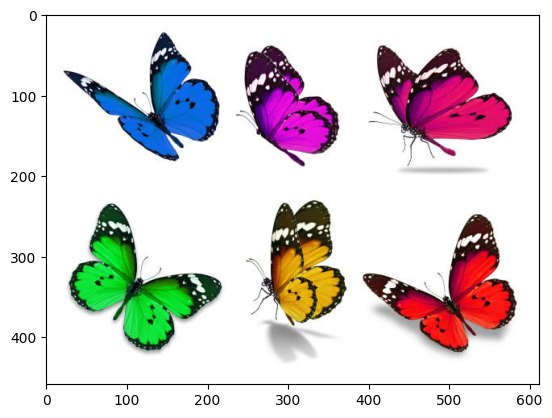

Borboleta


In [9]:
# Agora usamos o modelo para classificar uma imagem
# Primeiro definimos as classes
classes = ['Borboleta', 'Gafanhoto', 'Joaninha', 'Libélula', 'Mosquito']

# Agora carregamos uma imagem
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

img = Image.open('model_classes/test/Borboleta/istockphoto283.jpg') # Carregamos a imagem
plt.imshow(img)
plt.show()

# Agora preparamos a imagem para ser classificada
img = transform(img)
img = img.to(device)
img = img.unsqueeze(0)


# Por fim, classificamos a imagem
with torch.no_grad():
    output = model(img)
    _, predicted = torch.max(output.data, 1)
    print(classes[predicted.item()])


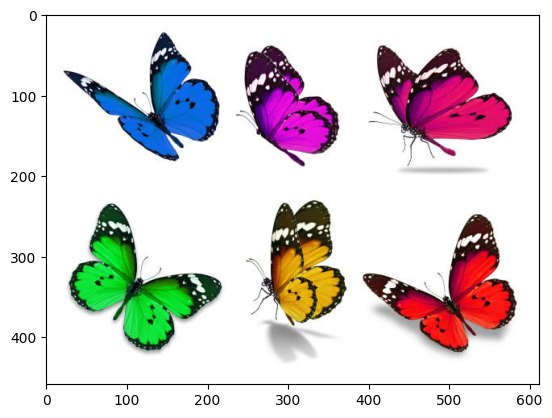

Borboleta


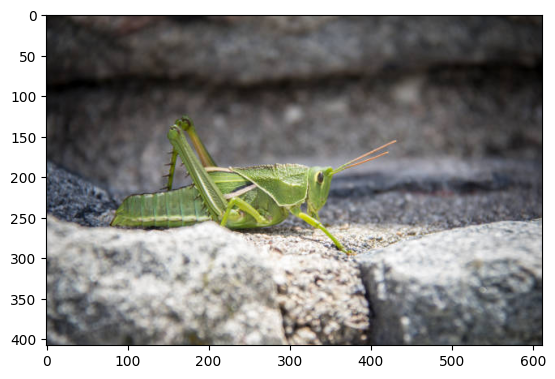

Gafanhoto


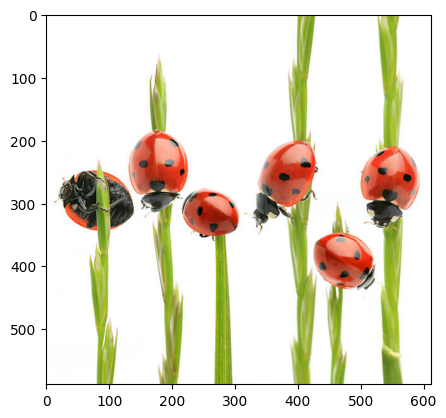

Joaninha


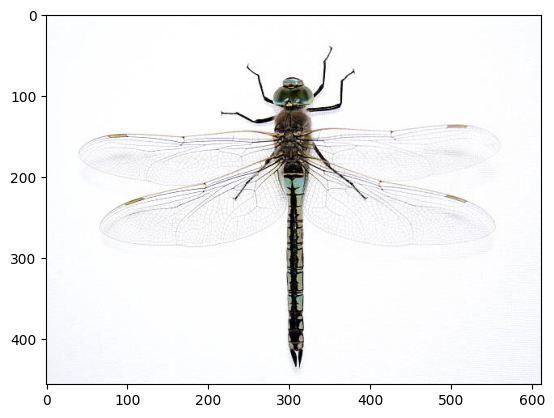

Libélula


In [16]:
# Vamos definir uma função para fazer mais testes de classificação
def predict_image(image_path):
    img = Image.open(image_path)
    plt.imshow(img)
    plt.show()
    img = transform(img)
    img = img.to(device)
    img = img.unsqueeze(0)
    with torch.no_grad():
        output = model(img)
        _, predicted = torch.max(output.data, 1)
        print(classes[predicted.item()])

# Agora vamos testar com mais imagens
predict_image('model_classes/test/Borboleta/istockphoto283.jpg')
predict_image('model_classes/test/Gafanhoto/istockphoto355.jpg')
predict_image('model_classes/test/Joaninha/istockphoto23.jpg')
predict_image('model_classes/test/Libélula/istockphoto370.jpg')